In [18]:
import numpy as np
import pandas as pd

Features: 
* Time peak
  - Check time series distribution relative to perofrmance (pure stats) and see if there's any merit to the time of peak of a player.
* Formula (Raw Score & With Peak & Probability).
  - Come up with formula to calculate the raw score (with and without peak) and the probability of winning all-nba.
  - My theory is that we'll have to group and compare stats by position (guard, forward, and center). Then we ought to arrange all players that season and see their average standing to calculate for the weights.
  - Another theory is that the time of peak performance of a player has an effect on the likelihood that an nba player will be picked as an all-nba player.
  - Team-success should also be considered.
* Compare to average game score per season
  - Test statistical significance (Correlation or MSE) between game score and winning all-nba modell.
* Testing of accuracy
  - For the probability, we could test using MSE. With 1 being an All-NBA player and 0 if not.
  - Or arange them by their score (from derrived formula) that season and show accurate our list is based on the official all-nba. 

Problems
* Stats to consider
  - Different positions have different emphasis (guards are more considered valuable if they could facilitate while centers are more valuable for their defensive output)
  - The challenge here lies in how to get these emphasis
  - My theory is we could get this through averaging the stats of all-nba players and non all-nba players and rank them based on their deviations. The more deviation, the higher emphasis.
* Training Model for weights?
  - regression logistic
* Should we remove the classic era?
  - It is possible to identify three main Eras that we define as the Classic Era of the NBA (1980–1994), the Transitional Era of the NBA (1995–2013), and the Modern Era of the NBA (since 2013) ([link](https://content.iospress.com/articles/journal-of-sports-analytics/jsa200525))  

## ALL NBA ORIGINAL CSV

In [19]:
df_season_awards = pd.read_csv('End of Season Teams (Voting).csv')
df_all_nba = df_season_awards[df_season_awards['type']=='All-NBA']
df_all_nba.head(10)

,season,lg,type,number_tm,position,player,age,tm,pts_won,pts_max,share,x1st_tm,x2nd_tm,x3rd_tm,seas_id,player_id
34,2024,NBA,All-NBA,1T,C,Nikola Jokić,28,DEN,495.0,495.0,1.000,99.0,0.0,0.0,31672,4352
35,2024,NBA,All-NBA,1T,G,Shai Gilgeous-Alexander,25,OKC,495.0,495.0,1.000,99.0,0.0,0.0,31769,4670
36,2024,NBA,All-NBA,1T,G,Luka Dončić,24,DAL,493.0,495.0,0.996,98.0,1.0,0.0,31593,4654
37,2024,NBA,All-NBA,1T,F,Giannis Antetokounmpo,29,MIL,473.0,495.0,0.956,88.0,11.0,0.0,31366,4164
38,2024,NBA,All-NBA,1T,F,Jayson Tatum,25,BOS,427.0,495.0,0.863,65.0,34.0,0.0,31468,4518
39,2024,NBA,All-NBA,2T,G,Jalen Brunson,27,NYK,368.0,495.0,0.743,37.0,61.0,0.0,31429,4630
40,2024,NBA,All-NBA,2T,G,Anthony Edwards,22,MIN,285.0,495.0,0.576,3.0,87.0,9.0,31171,4808
41,2024,NBA,All-NBA,2T,F,Kevin Durant,35,PHO,274.0,495.0,0.554,2.0,85.0,9.0,31551,3770
42,2024,NBA,All-NBA,2T,F,Kawhi Leonard,32,LAC,242.0,495.0,0.489,1.0,72.0,21.0,31531,4032
43,2024,NBA,All-NBA,2T,C,Anthony Davis,30,LAL,230.0,495.0,0.465,1.0,65.0,30.0,31170,4066


## Stats Per Game Original

In [20]:
df_season_stats = df_season_awards = pd.read_csv('Player Per Game.csv')
df_season_stats.head()

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,31871,2025,5025,A.J. Green,NaN,SG,25.0,3,NBA,MIL,...,1.000,0.0,0.4,0.4,0.6,0.2,0.0,0.2,0.2,3.4
1,31872,2025,5210,AJ Johnson,NaN,SG,20.0,1,NBA,MIL,...,NaN,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.7
2,31873,2025,4219,Aaron Gordon,NaN,PF,29.0,11,NBA,DEN,...,0.857,3.3,4.3,7.5,3.5,1.0,0.5,2.0,2.0,15.5
3,31874,2025,4582,Aaron Holiday,NaN,PG,28.0,7,NBA,HOU,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,31875,2025,4805,Aaron Nesmith,NaN,SF,25.0,5,NBA,IND,...,0.846,0.8,3.8,4.6,1.0,0.8,0.4,0.8,4.8,8.6


In [21]:
print(df_season_awards.duplicated(subset=['season', 'player_id']).sum())
print(df_season_stats.duplicated(subset=['season', 'player_id']).sum())

6053
6053


### Combining Duplicated rows
as it turns out, players who were traded half-way have separate entry. Before we could proceed accordingly, it is imperative to combine them.

In [22]:
def weighted_mean(series, weights):
    return (series * weights).sum() / weights.sum()

aggregation_dict = {
    'mp_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted minutes
    'fg_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted field goals
    'fga_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted field goal attempts
    'fg_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),    # Weighted FG%
    'x3p_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted 3-pointers made
    'x3pa_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']), # Weighted 3-point attempts
    'x3p_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted 3P%
    'x2p_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted 2-pointers made
    'x2pa_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']), # Weighted 2-point attempts
    'x2p_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted 2P%
    'e_fg_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted Effective FG%
    'ft_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted free throws
    'fta_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted free throw attempts
    'ft_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),    # Weighted FT%
    'orb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted offensive rebounds
    'drb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted defensive rebounds
    'trb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted total rebounds
    'ast_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted assists
    'stl_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted steals
    'blk_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted blocks
    'tov_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted turnovers
    'pf_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted personal fouls
    'pts_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted points
}

additional_aggregation = {
    'seas_id': 'first',  # Keep the first season ID
    'player': 'first',   # Keep the player's name
    'birth_year': 'first',  # Keep birth year
    'pos': 'first',  # Keep the first position
    'age': 'mean',   # Average age
    'experience': 'mean',  # Average experience
    'g': 'sum'       # Total games played
}

aggregation_dict.update(additional_aggregation)

# df_combined = df_season_stats.groupby(['season', 'player_id']).agg(aggregation_dict).reset_index()
# df_combined.head()

df_season_stats.dtypes

## Loading Fixed NBA Stats Per Game without duplicates


In [23]:
nba_stats_per_game = pd.read_csv('nba_per_game_no_duplicates.csv')
nba_stats_per_game

,season,player_id,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,tov_per_game,pf_per_game,pts_per_game,seas_id,player,birth_year,pos,age,experience,g
0,1947,1,0.0,3.8,15.0,0.256,0.0,0.0,0.000,3.8,...,0.0,2.0,9.8,1,Al Brightman,NaN,F,23.0,1.0,58
1,1947,2,0.0,0.2,1.6,0.125,0.0,0.0,0.000,0.2,...,0.0,1.2,0.8,2,Al Lujack,NaN,F,26.0,1.0,5
2,1947,3,0.0,1.2,6.3,0.188,0.0,0.0,0.000,1.2,...,0.0,1.8,2.8,3,Al Negratti,NaN,F-C,25.0,1.0,11
3,1947,4,0.0,3.8,13.6,0.281,0.0,0.0,0.000,3.8,...,0.0,2.0,9.4,4,Angelo Musi,NaN,G,28.0,1.0,60
4,1947,5,0.0,3.8,15.7,0.241,0.0,0.0,0.000,3.8,...,0.0,3.1,9.0,5,Ariel Maughan,1923.0,F,23.0,1.0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,2025,5258,1.5,0.0,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.5,32274,Yongxi Cui,NaN,SG,21.0,1.0,2
26226,2025,5259,2.5,0.0,1.0,0.000,0.0,1.0,0.000,0.0,...,0.3,0.0,0.0,32275,Yuki Kawamura,NaN,PG,23.0,1.0,4
26227,2025,5260,19.8,2.6,5.6,0.464,0.0,0.0,0.000,2.6,...,0.8,1.6,6.8,32276,Yves Missi,NaN,C,20.0,1.0,5
26228,2025,5261,25.0,3.4,9.6,0.354,1.0,4.2,0.238,2.4,...,1.2,2.6,9.2,32277,Zaccharie Risacher,NaN,SF,19.0,1.0,5


## All NBA List with Stats

In [24]:
all_nba_stats = pd.read_csv('all_nba_with_stats.csv')
all_nba_stats

,season,lg,type,number_tm,position,player_x,age_x,tm,pts_won,pts_max,...,tov_per_game,pf_per_game,pts_per_game,seas_id_y,player_y,birth_year,pos,age_y,experience,g
0,2024,NBA,All-NBA,1T,C,Nikola Jokić,28,DEN,495.0,495.0,...,3.000000,2.500000,26.40000,31672,Nikola Jokić,NaN,C,28.0,9.0,79
1,2024,NBA,All-NBA,1T,G,Shai Gilgeous-Alexander,25,OKC,495.0,495.0,...,0.610417,1.133333,4.50625,31770,Shake Milton,NaN,SG,27.0,6.0,96
2,2024,NBA,All-NBA,1T,F,Giannis Antetokounmpo,29,MIL,473.0,495.0,...,3.400000,2.900000,30.40000,31366,Giannis Antetokounmpo,NaN,PF,29.0,11.0,73
3,2024,NBA,All-NBA,1T,F,Jayson Tatum,25,BOS,427.0,495.0,...,2.500000,2.000000,26.90000,31468,Jayson Tatum,NaN,PF,25.0,7.0,74
4,2024,NBA,All-NBA,2T,G,Anthony Edwards,22,MIN,285.0,495.0,...,3.100000,1.800000,25.90000,31171,Anthony Edwards,NaN,SG,22.0,4.0,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1966,NBA,All-NBA,2nd,C,Bill Russell,31,BOS,5.0,9.0,...,0.000000,2.800000,12.90000,2865,Bill Russell,NaN,C,31.0,10.0,78
1733,1966,NBA,All-NBA,2nd,G,Sam Jones,32,BOS,4.0,9.0,...,0.000000,2.500000,23.50000,2964,Sam Jones,NaN,SG,32.0,9.0,67
1734,1966,NBA,All-NBA,2nd,F,John Havlicek,25,BOS,4.0,9.0,...,0.000000,2.200000,18.80000,2926,John Havlicek,NaN,SF,25.0,4.0,71
1735,1966,NBA,All-NBA,2nd,G,Hal Greer,29,PHI,2.0,9.0,...,0.000000,3.900000,22.70000,2903,Hal Greer,NaN,SG,29.0,8.0,80


### Error Fixing, Luka Missing in the above CSV
(saved as "nba_per_game_fixed.csv")

In [25]:
# df_luka_awards = df_all_nba[(df_all_nba['player'] == 'Luka Dončić') & (df_all_nba['season'] == 2024)]
# df_luka_stats = df_season_stats[(df_season_stats['player'] == 'Luka Dončić') & (df_season_stats['season'] == 2024)]
# df_combined_new = pd.concat([df_luka_awards, df_luka_stats], ignore_index=True)
# df_combined_row = df_combined_new.loc[0].combine_first(df_combined_new.loc[1])

# df_result = pd.DataFrame([df_combined_row])
# df_result['player_x'] = 'Luka Dončić'
# df_result['position'] = 'G'
# df_result['age_x'] = 24

# all_nba_stats = pd.concat([all_nba_stats, df_result], ignore_index=True)
# all_nba_stats.to_csv('nba_per_game_fixed.csv', index=False)
all_nba_with_stats = pd.read_csv('nba_per_game_fixed.csv')
all_nba_with_stats

,season,lg,type,number_tm,position,player_x,age_x,tm,pts_won,pts_max,...,player_y,birth_year,pos,age_y,experience,g,player,age,seas_id,gs
0,2024,NBA,All-NBA,1T,C,Nikola Jokić,28,DEN,495.0,495.0,...,Nikola Jokić,NaN,C,28.0,9.0,79.0,NaN,NaN,NaN,NaN
1,2024,NBA,All-NBA,1T,G,Shai Gilgeous-Alexander,25,OKC,495.0,495.0,...,Shake Milton,NaN,SG,27.0,6.0,96.0,NaN,NaN,NaN,NaN
2,2024,NBA,All-NBA,1T,F,Giannis Antetokounmpo,29,MIL,473.0,495.0,...,Giannis Antetokounmpo,NaN,PF,29.0,11.0,73.0,NaN,NaN,NaN,NaN
3,2024,NBA,All-NBA,1T,F,Jayson Tatum,25,BOS,427.0,495.0,...,Jayson Tatum,NaN,PF,25.0,7.0,74.0,NaN,NaN,NaN,NaN
4,2024,NBA,All-NBA,2T,G,Anthony Edwards,22,MIN,285.0,495.0,...,Anthony Edwards,NaN,SG,22.0,4.0,79.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1966,NBA,All-NBA,2nd,G,Sam Jones,32,BOS,4.0,9.0,...,Sam Jones,NaN,SG,32.0,9.0,67.0,NaN,NaN,NaN,NaN
1734,1966,NBA,All-NBA,2nd,F,John Havlicek,25,BOS,4.0,9.0,...,John Havlicek,NaN,SF,25.0,4.0,71.0,NaN,NaN,NaN,NaN
1735,1966,NBA,All-NBA,2nd,G,Hal Greer,29,PHI,2.0,9.0,...,Hal Greer,NaN,SG,29.0,8.0,80.0,NaN,NaN,NaN,NaN
1736,1966,NBA,All-NBA,2nd,F,Gus Johnson,27,BAL,2.0,9.0,...,Gus Johnson,1938.0,SF,27.0,3.0,41.0,NaN,NaN,NaN,NaN


### Available Positions

In [26]:
nba_stats_per_game['pos'].unique()

array(['F', 'F-C', 'G', 'C', 'G-F', 'SG', 'F-G', 'SF', 'C-F', 'PG', 'PF',
       'SG-PG', 'PF-C', 'SF-SG', 'C-PF', 'SG-SF', 'PG-SG', 'PF-SF',
       'SF-PF', 'SF-PG', 'C-SF', 'PG-SF', 'SG-PF', 'SF-C', 'SG-PG-SF'],
      dtype=object)

## Calculating Stats Per Season And Postion
Here, I included the players who has two postions in calculations. For example, Tim Duncan stats is included in calculation of average statistics in both the Forward and center positions.

In [27]:
df_season_info_players = pd.read_csv('Player Season Info.csv')
df_season_info_players.rename(columns={'pos': 'eligible_position'}, inplace=True)
df_season_info_players.head()
df_season_stats_new = nba_stats_per_game.merge(
    df_season_info_players[['season', 'player_id', 'eligible_position']], 
    how='left',
    on=['season', 'player_id']
)
df_season_stats_new[df_season_stats_new['season']>= 1979]['eligible_position'].unique()
df_season_stats_new['eligible_position'] = df_season_stats_new['eligible_position'].str.strip().str.upper()
df_season_stats_new_new = df_season_stats_new.assign(
    expanded_positions=df_season_stats_new['eligible_position'].str.split('-')
)

expanded_stats = df_season_stats_new_new.explode('expanded_positions')
expanded_stats = expanded_stats.rename(columns={'expanded_positions': 'primary_pos'})

def map_primary_pos(pos):
    if isinstance(pos, str):
        if 'G' in pos:
            return 'G'
        elif 'F' in pos:
            return 'F'
        elif 'C' in pos:
            return 'C'
    return None

expanded_stats['mapped_pos'] = expanded_stats['primary_pos'].apply(map_primary_pos)

filtered_stats = expanded_stats[expanded_stats['mapped_pos'].notna()]
filtered_stats = filtered_stats[filtered_stats['season'] >= 1979]

stats_list = list(aggregation_dict.items())
numeric_columns = [x[0] for x in stats_list if x[0] != 'player' and x[0] != 'pos']
filtered_stats_new = filtered_stats[numeric_columns + ['season', 'mapped_pos']]

average_stats_by_season_pos = (
    filtered_stats_new.groupby(['season', 'mapped_pos'])[numeric_columns]
    .mean()
    .reset_index()
)
average_stats_by_season_pos = average_stats_by_season_pos.drop(columns=['birth_year', 'experience', 'age', 'seas_id'])

average_stats_by_season_pos

,season,mapped_pos,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,g
0,1979,C,22.160610,3.794890,7.615368,0.477111,0.000000,0.000000,0.000000,3.794890,...,2.043494,4.445156,6.480370,1.675883,0.578939,0.993442,1.822025,2.770788,9.455703,87.089552
1,1979,F,21.061238,3.921360,8.022316,0.473698,0.000000,0.000000,0.000000,3.921360,...,1.571457,3.123665,4.690446,1.611459,0.705524,0.471547,1.686488,2.371412,9.745082,74.841727
2,1979,G,21.279241,3.930540,8.521881,0.443766,0.000000,0.000000,0.000000,3.930540,...,0.698697,1.337839,2.027832,3.059670,1.006183,0.181549,1.826105,2.028465,9.675771,81.388489
3,1980,C,23.317605,3.789275,7.569953,0.483515,0.000537,0.020997,0.042829,3.787785,...,2.054681,4.578006,6.637407,1.836599,0.640671,1.006769,1.744359,2.747662,9.478759,83.246154
4,1980,F,22.008321,3.982965,8.308488,0.465798,0.038750,0.159331,0.134787,3.943292,...,1.684808,3.186891,4.873173,1.755439,0.763774,0.502807,1.716703,2.487789,9.963840,78.724832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2024,F,18.357168,2.876683,6.199776,0.443264,0.932375,2.624519,0.317992,1.946670,...,0.836489,2.495087,3.321697,1.481115,0.569007,0.387090,0.843445,1.449650,7.774149,61.576052
137,2024,G,18.650445,3.067369,7.029025,0.413099,1.119601,3.165095,0.317107,1.943717,...,0.494852,1.931283,2.422522,2.619466,0.639854,0.235533,1.046062,1.336125,8.470485,61.281046
138,2025,C,19.177966,3.345763,6.010169,0.543254,0.450847,1.172881,0.207085,2.896610,...,1.776271,4.133898,5.906780,1.522034,0.503390,0.822034,1.133898,2.045763,8.752542,4.016949
139,2025,F,18.996774,3.080000,6.776129,0.426710,0.916774,2.721935,0.263090,2.168387,...,1.081935,2.822581,3.897419,1.578065,0.643871,0.471613,1.047742,1.740000,8.506452,3.896774


In [28]:
all_nba_with_stats_grouped = all_nba_with_stats.groupby(['season', 'position']).mean(numeric_only=True)
all_nba_with_stats_grouped

age_x     pts_won  pts_max     share    x1st_tm  \
season position                                                        
1966   C         30.000000    6.500000      9.0  0.740500        NaN   
       F         24.500000    5.500000      9.0  0.594750        NaN   
       G         28.750000    6.000000      9.0  0.662000  85.000000   
1967   C         31.000000    7.000000     10.0  0.690500        NaN   
       F         26.000000    5.750000     10.0  0.569500        NaN   
...                    ...         ...      ...       ...        ...   
2023   F         28.562500  105.375000    500.0  0.210750  12.125000   
       G         26.923077  134.769231    500.0  0.269538  14.384615   
2024   C         27.000000  151.000000    495.0  0.305000  20.000000   
       F         28.428571  205.428571    495.0  0.415143  22.285714   
       G         25.625000  195.000000    495.0  0.393875  25.000000   

                   x2nd_tm    x3rd_tm     seas_id_x    player_id  mp_per_game  \
season position                                                                 
1966   C               NaN        NaN   2924.500000   654.500000    45.350000   
       F               NaN        NaN   2923.000000   808.000000    35.950000   
       G               NaN        NaN   2932.000000   685.250000    40.125000   
1967   C               NaN        NaN   3056.500000   654.500000    43.100000   
       F               NaN        NaN   3071.000000   790.000000    39.875000   
...                    ...        ...           ...          ...          ...   
2023   F         10.750000  12.500000  30810.312500  4241.312500    34.817995   
       G         16.000000  14.846154  30804.923077  4407.769231    34.707692   
2024   C         13.800000   9.600000  31523.400000  4459.600000    33.580000   
       F         29.285714   6.142857  31540.285714  4321.142857    35.242857   
       G         14.000000  28.000000  31573.714286  4578.750000    32.374479   

                 ...  pf_per_game  pts_per_game     seas_id_y  birth_year  \
season position  ...                                                        
1966   C         ...     2.500000     23.200000   2924.500000         NaN   
       F         ...     3.175000     20.625000   2923.000000      1941.0   
       G         ...     3.125000     27.200000   2932.000000         NaN   
1967   C         ...     2.500000     18.700000   3056.500000         NaN   
       F         ...     3.400000     25.225000   3071.000000      1944.0   
...              ...          ...           ...           ...         ...   
2023   F         ...     2.383813     25.236419  30810.312500         NaN   
       G         ...     2.092308     26.453846  30804.923077         NaN   
2024   C         ...     2.460000     21.160000  31523.400000         NaN   
       F         ...     2.042857     25.371429  31540.285714         NaN   
       G         ...     1.941667     23.800781  31573.857143         NaN   

                     age_y  experience          g   age  seas_id    gs  
season position                                                         
1966   C         30.000000    8.500000  78.500000   NaN      NaN   NaN  
       F         24.500000    2.750000  67.750000   NaN      NaN   NaN  
       G         28.750000    7.250000  75.500000   NaN      NaN   NaN  
1967   C         31.000000    9.500000  81.000000   NaN      NaN   NaN  
       F         26.000000    4.500000  76.750000   NaN      NaN   NaN  
...                    ...         ...        ...   ...      ...   ...  
2023   F         28.562500    9.500000  74.875000   NaN      NaN   NaN  
       G         26.923077    7.692308  63.461538   NaN      NaN   NaN  
2024   C         27.000000    8.000000  74.600000   NaN      NaN   NaN  
       F         28.428571    9.571429  74.142857   NaN      NaN   NaN  
       G         26.142857    6.875000  75.000000  24.0  31593.0  70.0  

[177 rows x 40 columns]

In [29]:
all_nba_with_stats_grouped.dtypes

age_x            float64
pts_won          float64
pts_max          float64
share            float64
x1st_tm          float64
x2nd_tm          float64
x3rd_tm          float64
seas_id_x        float64
player_id        float64
mp_per_game      float64
fg_per_game      float64
fga_per_game     float64
fg_percent       float64
x3p_per_game     float64
x3pa_per_game    float64
x3p_percent      float64
x2p_per_game     float64
x2pa_per_game    float64
x2p_percent      float64
e_fg_percent     float64
ft_per_game      float64
fta_per_game     float64
ft_percent       float64
orb_per_game     float64
drb_per_game     float64
trb_per_game     float64
ast_per_game     float64
stl_per_game     float64
blk_per_game     float64
tov_per_game     float64
pf_per_game      float64
pts_per_game     float64
seas_id_y        float64
birth_year       float64
age_y            float64
experience       float64
g                float64
age              float64
seas_id          float64
gs               float64


In [30]:
average_stats_by_season_pos.dtypes

season             int64
mapped_pos        object
mp_per_game      float64
fg_per_game      float64
fga_per_game     float64
fg_percent       float64
x3p_per_game     float64
x3pa_per_game    float64
x3p_percent      float64
x2p_per_game     float64
x2pa_per_game    float64
x2p_percent      float64
e_fg_percent     float64
ft_per_game      float64
fta_per_game     float64
ft_percent       float64
orb_per_game     float64
drb_per_game     float64
trb_per_game     float64
ast_per_game     float64
stl_per_game     float64
blk_per_game     float64
tov_per_game     float64
pf_per_game      float64
pts_per_game     float64
g                float64
dtype: object

## Calculating Deviation (All NBA Playes minus Average NBA Players)

In [31]:
# average_stats_by_season_pos.rename(columns={'mapped_pos': 'position'}, inplace=True)

# columns_to_compare = [
#     "mp_per_game", "fg_percent", "x3p_percent", "x2p_percent", "e_fg_percent",
#     "ft_percent", "orb_per_game", "drb_per_game", "trb_per_game", "ast_per_game",
#     "stl_per_game", "blk_per_game", "tov_per_game", "pf_per_game", "pts_per_game", "g"
# ]

# df1_grouped = all_nba_with_stats[all_nba_with_stats['season'] > 1978].groupby(['season', 'position'])[columns_to_compare].mean()
# df2_grouped = average_stats_by_season_pos.groupby(['season', 'position'])[columns_to_compare].mean()

# deviation = (df1_grouped - df2_grouped)
# deviation

# New Path (This renders the ALL-NBA chuchuness obselete, sadly)
## Deviation of each NBA players ('NBA players stats' - 'Average NBA Players')
Each NBA Player stats is in 'filetered_stats' df

Average NBA player stats by season is in 'average_stats_by_season_pos'

### With Consideration to positions

In [32]:
# average_stats_by_season_pos.rename(columns={'mapped_pos': 'position'}, inplace=True)

merged_stats = pd.merge(
    filtered_stats,
    average_stats_by_season_pos,
    on=['season', 'mapped_pos'],
    suffixes=('', '_avg') 
)

columns_to_calculate = [col for col in average_stats_by_season_pos.columns if col not in ['season', 'mapped_pos']]

for col in columns_to_calculate:
    merged_stats[f'{col}_deviation'] = merged_stats[col] - merged_stats[f'{col}_avg']

columns_to_drop = [f'{col}_avg' for col in columns_to_calculate]
final_stats_deviation_by_pos = merged_stats.drop(columns=columns_to_drop)

final_stats_deviation_by_pos.dtypes

season                       int64
player_id                    int64
mp_per_game                float64
fg_per_game                float64
fga_per_game               float64
fg_percent                 float64
x3p_per_game               float64
x3pa_per_game              float64
x3p_percent                float64
x2p_per_game               float64
x2pa_per_game              float64
x2p_percent                float64
e_fg_percent               float64
ft_per_game                float64
fta_per_game               float64
ft_percent                 float64
orb_per_game               float64
drb_per_game               float64
trb_per_game               float64
ast_per_game               float64
stl_per_game               float64
blk_per_game               float64
tov_per_game               float64
pf_per_game                float64
pts_per_game               float64
seas_id                      int64
player                      object
birth_year                 float64
pos                 

In [33]:
average_stats_by_season_pos

,season,mapped_pos,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,g
0,1979,C,22.160610,3.794890,7.615368,0.477111,0.000000,0.000000,0.000000,3.794890,...,2.043494,4.445156,6.480370,1.675883,0.578939,0.993442,1.822025,2.770788,9.455703,87.089552
1,1979,F,21.061238,3.921360,8.022316,0.473698,0.000000,0.000000,0.000000,3.921360,...,1.571457,3.123665,4.690446,1.611459,0.705524,0.471547,1.686488,2.371412,9.745082,74.841727
2,1979,G,21.279241,3.930540,8.521881,0.443766,0.000000,0.000000,0.000000,3.930540,...,0.698697,1.337839,2.027832,3.059670,1.006183,0.181549,1.826105,2.028465,9.675771,81.388489
3,1980,C,23.317605,3.789275,7.569953,0.483515,0.000537,0.020997,0.042829,3.787785,...,2.054681,4.578006,6.637407,1.836599,0.640671,1.006769,1.744359,2.747662,9.478759,83.246154
4,1980,F,22.008321,3.982965,8.308488,0.465798,0.038750,0.159331,0.134787,3.943292,...,1.684808,3.186891,4.873173,1.755439,0.763774,0.502807,1.716703,2.487789,9.963840,78.724832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2024,F,18.357168,2.876683,6.199776,0.443264,0.932375,2.624519,0.317992,1.946670,...,0.836489,2.495087,3.321697,1.481115,0.569007,0.387090,0.843445,1.449650,7.774149,61.576052
137,2024,G,18.650445,3.067369,7.029025,0.413099,1.119601,3.165095,0.317107,1.943717,...,0.494852,1.931283,2.422522,2.619466,0.639854,0.235533,1.046062,1.336125,8.470485,61.281046
138,2025,C,19.177966,3.345763,6.010169,0.543254,0.450847,1.172881,0.207085,2.896610,...,1.776271,4.133898,5.906780,1.522034,0.503390,0.822034,1.133898,2.045763,8.752542,4.016949
139,2025,F,18.996774,3.080000,6.776129,0.426710,0.916774,2.721935,0.263090,2.168387,...,1.081935,2.822581,3.897419,1.578065,0.643871,0.471613,1.047742,1.740000,8.506452,3.896774


# Principal Component Analysis (PCA)
PCA, in simple sense, simplyfy complex data by finding patterns and looking for correlation between different variables. By looking at their correlation, PCA will combine the correlated variables and put them in a single component (*principal component*). After that, PCA will rank the variables by how much variation (or 'importance') each component has. The more variant a component is, the more important it is because it helps us distinguish between high performing and low performing players. As opposed to lower variance, it may only mean noise so this doesn't help us much when distinguishing player's performances. These "importance" will serve as a weight for the final formula.

## PCA Assumptions
1. **PCA assumes a correlation between features**. If the features (or dimensions or columns, in tabular data) are not correlated, PCA will be unable to determine principal components.
2. **PCA is sensitive to the scale of the features**. Imagine we have two features - one takes values between 0 and 1000, while the other takes values between 0 and 1. PCA will be extremely biased towards the first feature being the first principle component, regardless of the actual maximum variance within the data. This is why it’s so important to standardize the values first.
3. **PCA is not robust against outliers**. Similar to the point above, the algorithm will be biased in datasets with strong outliers. This is why it is recommended to remove outliers before performing PCA.
4. **PCA assumes a linear relationship between features**. The algorithm is not well suited to capturing non-linear relationships. That’s why it’s advised to turn non-linear features or relationships between features into linear, using the standard methods such as log transforms.
5. **Technical implementations often assume no missing values**. When computing PCA using statistical software tools, they often assume that the feature set has no missing values (no empty rows). Be sure to remove those rows and/or columns with missing values, or impute missing values with a close approximation (e.g. the mean of the column).

Source: https://www.keboola.com/blog/pca-machine-learning

Should we make  PPT???

Should I also add overall data??????

### Assumption 1: PCA assumes a correlation between features
This holds in our dataset due to some columns being correlated. For example, pts per game and fg_per_game and fga_per_game are all highly correlated to each other. 

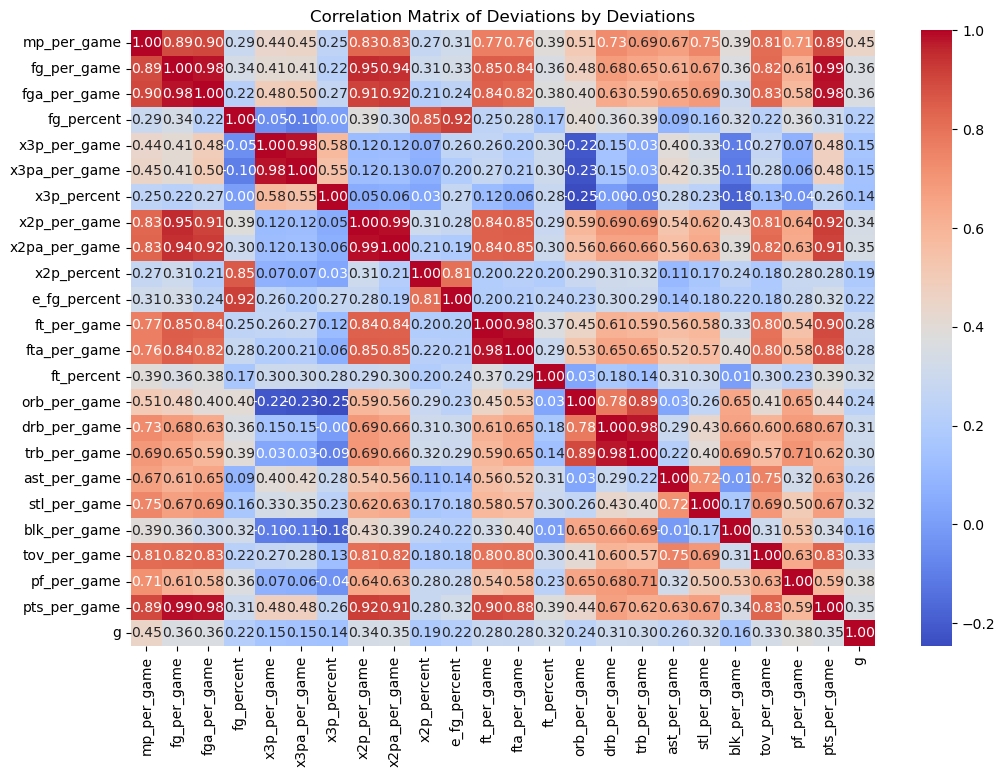

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
correlation = final_stats_deviation_by_pos[columns_to_calculate].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Deviations by Deviations")
plt.show()

### Assumption 2: PCA is sensitive to the scale of the features
To achieve this assumption, we have to standardize the dataset. 
We have two choices: 

#### *Z-Score*
$$
z = \frac{x_{col} - \overline{x}_{col}}{s_{col}}
$$

Where: <br>
$x_{col}$ = original value of a row in 'col' column. <br>
$\overline{x}_{col}$ = mean of the 'col' column.<br>
$s_{col}$ = is the standard deviation of 'col' column.<br>
and $z$ is the z-score.

Upon getting the z-score, each cells will have a mean of 0 and a standard deviation of 1, which standardizes the data.

#### *X-Scaled*
$$
x_{scaled} = \frac{x_{col} - MEDIAN_{col}}{IQR_{col}}
$$

Where: <br>
$x_{col}$ = original value of a row in 'col' column. <br>
$MEDIAN_{col}$ = median of the 'col' column.<br>
$IQR_{col}$ = is the IQR of 'col' column (calculated by 75th Percentile minus 25th Percentile).<br>
and $x_{scaled}$ is the scaled value.

Upon getting the x-scaled, each cells will have a median of 0 and IQR of 1, which standardizes the data.

#### Difference
The difference is that X-Scaled method is more robust to outlier and skewed distribution rather than Z-Score method. If we use z-score, we have to remove the outliers becuase Z-score method exaggerates the effect of outliers, making the procedure of PAC unreliable. Removing outliers isn't ideal because we want to retain those high-performers because they are crucial for differentation between average players. **We shall proceed with X-Scaled** method to minimize the effect of outliers while retaining them.


In [54]:
medians = final_stats_deviation_by_pos[columns_to_calculate].median()
iqrs = final_stats_deviation_by_pos[columns_to_calculate].quantile(0.75) - final_stats_deviation_by_pos[columns_to_calculate].quantile(0.25)

final_stats_standardized = final_stats_deviation_by_pos[columns_to_calculate].apply(
    lambda x: (x - medians[x.name]) / iqrs[x.name], axis=0
)

final_stats_standardized = pd.concat(
    [final_stats_deviation_by_pos.drop(columns=columns_to_calculate), final_stats_standardized],
    axis=1
)

print('Median per column (should be ~0)')
print(round(final_stats_standardized[columns_to_calculate].median()))

print('\nIQR per column (scaled, should be ~1)')
print(round(final_stats_standardized[columns_to_calculate].quantile(0.75) - final_stats_standardized[columns_to_calculate].quantile(0.25)))


Median per column (should be ~0)
mp_per_game      0.0
fg_per_game      0.0
fga_per_game     0.0
fg_percent       0.0
x3p_per_game     0.0
x3pa_per_game    0.0
x3p_percent      0.0
x2p_per_game     0.0
x2pa_per_game    0.0
x2p_percent      0.0
e_fg_percent     0.0
ft_per_game      0.0
fta_per_game     0.0
ft_percent       0.0
orb_per_game     0.0
drb_per_game     0.0
trb_per_game     0.0
ast_per_game     0.0
stl_per_game     0.0
blk_per_game     0.0
tov_per_game     0.0
pf_per_game      0.0
pts_per_game     0.0
g                0.0
dtype: float64

IQR per column (scaled, should be ~1)
mp_per_game      1.0
fg_per_game      1.0
fga_per_game     1.0
fg_percent       1.0
x3p_per_game     1.0
x3pa_per_game    1.0
x3p_percent      1.0
x2p_per_game     1.0
x2pa_per_game    1.0
x2p_percent      1.0
e_fg_percent     1.0
ft_per_game      1.0
fta_per_game     1.0
ft_percent       1.0
orb_per_game     1.0
drb_per_game     1.0
trb_per_game     1.0
ast_per_game     1.0
stl_per_game     1.0
blk_per_ga

### Assumption 3: PCA is not robust against outliers
This is accounted for from the previous assumption solution (the data has been X-Scaled). But just to check, here's the distribution for each column comparing the two methods (Z-Score and X-Scaled):


In [55]:
std_cols = final_stats_deviation_by_pos[columns_to_calculate].std()
std_mean = final_stats_deviation_by_pos[columns_to_calculate].mean()

final_stats_standardized_z = final_stats_deviation_by_pos[columns_to_calculate].apply(
    lambda x: (x - std_mean[x.name]) / std_cols[x.name], axis=0
)

final_stats_standardized_z = pd.concat(
    [final_stats_deviation_by_pos.drop(columns=columns_to_calculate), final_stats_standardized_z],
    axis=1
)

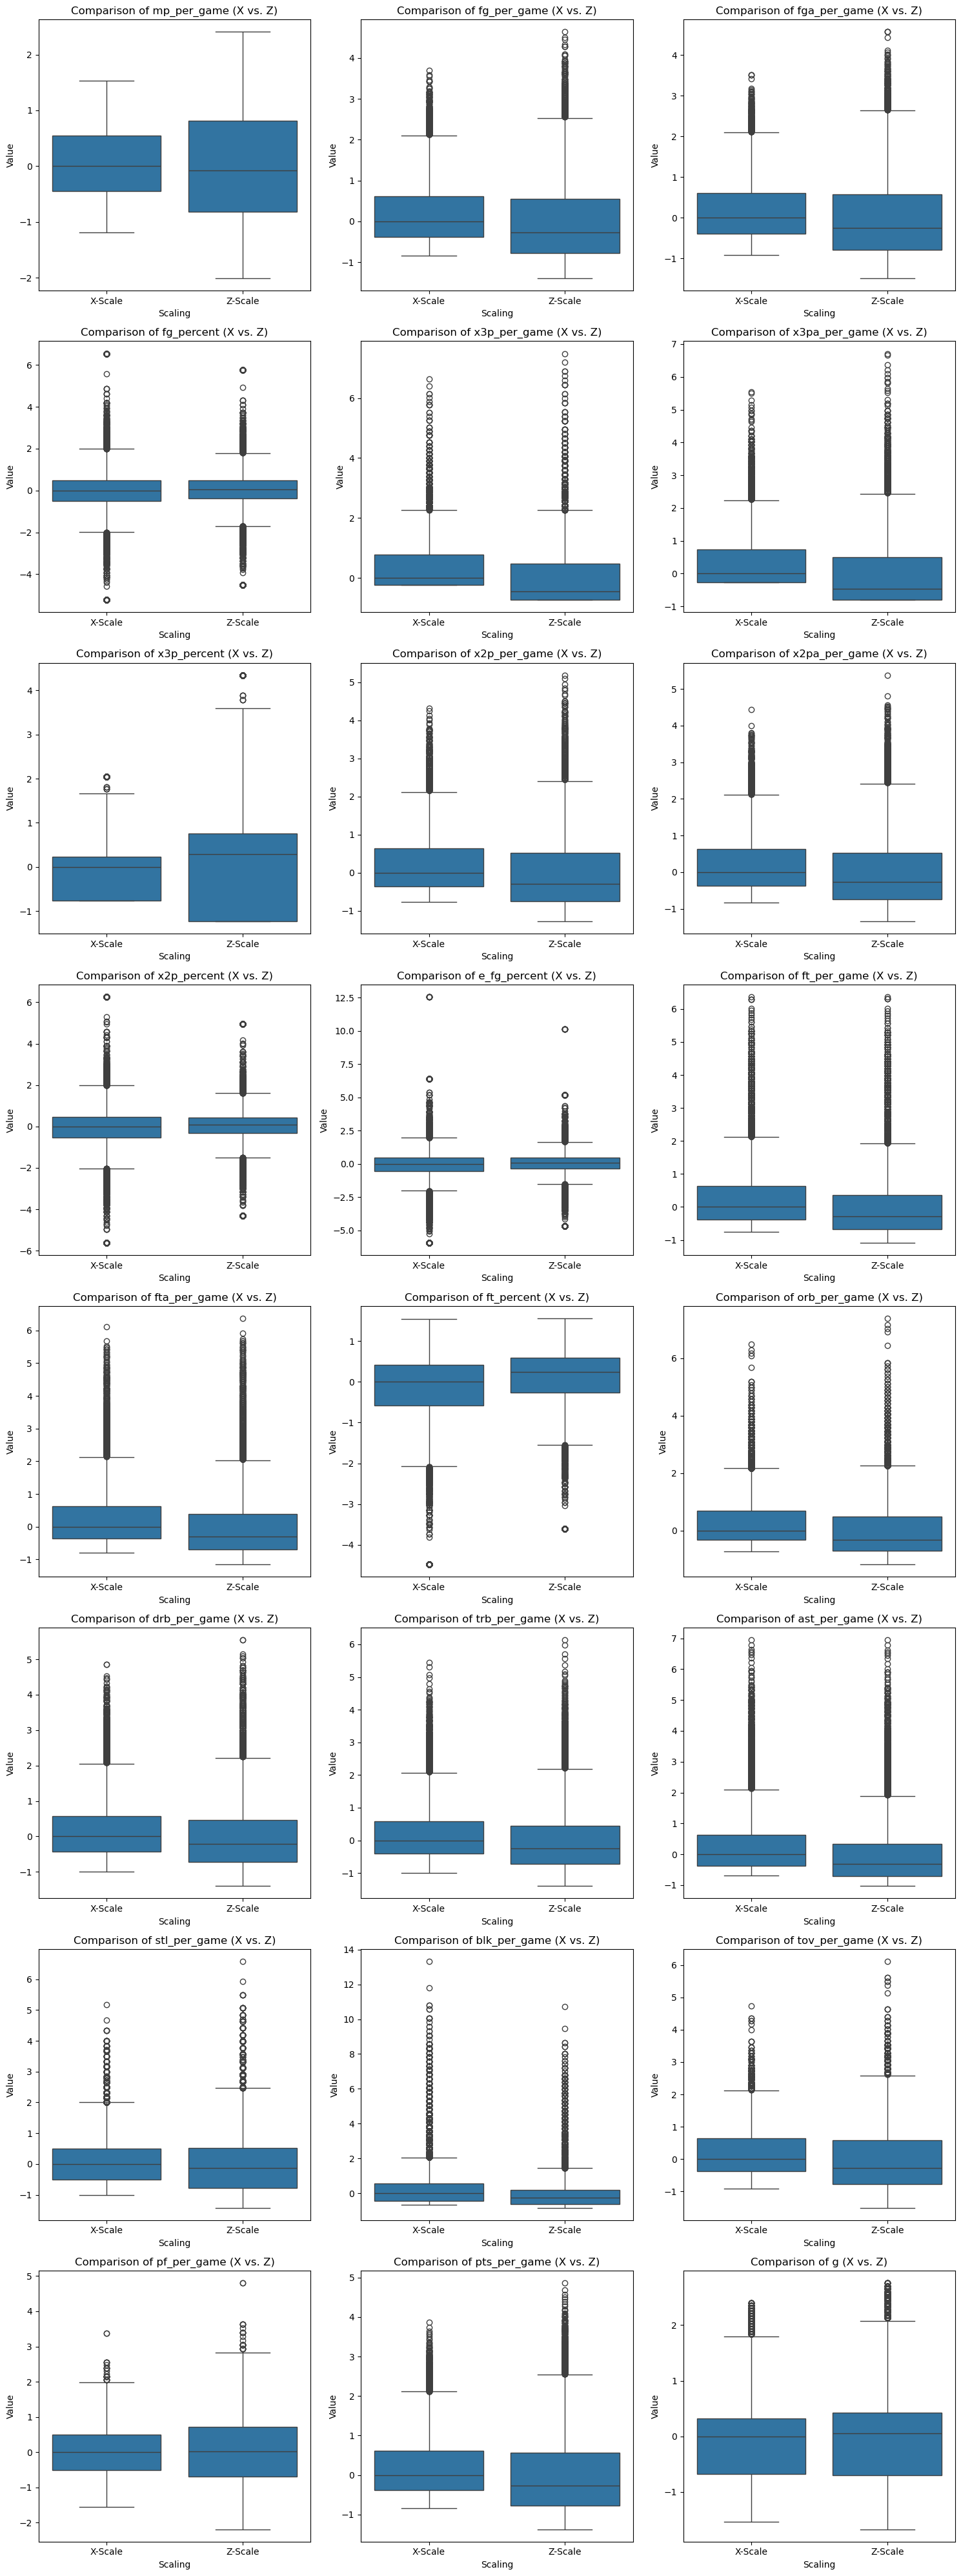

In [57]:
import math

num_columns = len(columns_to_calculate)

cols_per_row = 3
rows = math.ceil(num_columns / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows)) 
axes = axes.flatten()

for i, col in enumerate(columns_to_calculate):
    comparison_data = pd.DataFrame({
        'Value': pd.concat([final_stats_standardized[col], final_stats_standardized_z[col]]),
        'Scaling': ['X-Scale'] * len(final_stats_standardized) + ['Z-Scale'] * len(final_stats_standardized_z),
    })
    
    sns.boxplot(x='Scaling', y='Value', data=comparison_data, ax=axes[i])
    axes[i].set_title(f"Comparison of {col} (X vs. Z)")

for j in range(num_columns, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('comp_x_z.png')

### Assumption 4: PCA assumes a linear relationship between features.
Since we are only trying to look for weights in a formula, we are essentailly computing for linear combination that determine a player's performance. So this still holds.

### Assumption 5: Technical implementations often assume no missing values.

In [60]:
na_count_per_column = final_stats_standardized[columns_to_calculate].isna().sum()

print(na_count_per_column)

mp_per_game      0
fg_per_game      0
fga_per_game     0
fg_percent       0
x3p_per_game     0
x3pa_per_game    0
x3p_percent      0
x2p_per_game     0
x2pa_per_game    0
x2p_percent      0
e_fg_percent     0
ft_per_game      0
fta_per_game     0
ft_percent       0
orb_per_game     0
drb_per_game     0
trb_per_game     0
ast_per_game     0
stl_per_game     0
blk_per_game     0
tov_per_game     0
pf_per_game      0
pts_per_game     0
g                0
dtype: int64


## PCA TRAINING

In [61]:
from sklearn.decomposition import PCA


data_for_pca = final_stats_standardized[columns_to_calculate]
pca = PCA()

pca_results = pca.fit_transform(data_for_pca)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = explained_variance_ratio.cumsum()

print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)

Explained Variance Ratio: [4.37264095e-01 1.76396299e-01 1.29762615e-01 5.32977068e-02
 5.14690844e-02 3.42450490e-02 2.62424541e-02 2.14592930e-02
 1.74943709e-02 1.33043720e-02 1.07035236e-02 9.24624049e-03
 6.74137925e-03 4.79925577e-03 3.53365723e-03 1.46579194e-03
 1.18148462e-03 5.69524065e-04 4.64174485e-04 3.43680610e-04
 7.26422493e-06 5.22983700e-06 2.21006924e-06 1.24447144e-06]
Cumulative Explained Variance: [0.4372641  0.61366039 0.74342301 0.79672072 0.8481898  0.88243485
 0.9086773  0.9301366  0.94763097 0.96093534 0.97163886 0.9808851
 0.98762648 0.99242574 0.9959594  0.99742519 0.99860667 0.9991762
 0.99964037 0.99998405 0.99999132 0.99999655 0.99999876 1.        ]


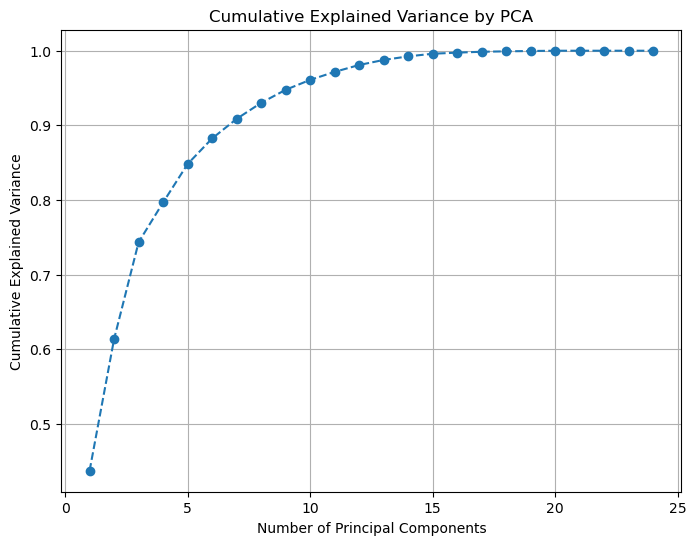

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid()
plt.show()

In [63]:
n_components = sum(cumulative_variance < 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components}")

Number of components to explain 95% variance: 10


In [64]:
pca_final = PCA(n_components=n_components)
pca_transformed_data = pca_final.fit_transform(data_for_pca)

pca_df = pd.DataFrame(
    pca_transformed_data,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

print(pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.030869 -0.166765  2.038677  0.177972 -0.374143  0.672815 -1.073679   
1  1.808016 -1.483973 -0.534199 -0.278627 -2.145059  0.310859  0.858217   
2  2.565130 -1.443193 -0.563636  0.231700 -1.873526  0.525835  1.682309   
3 -2.373618  0.342846 -0.496127  0.823993 -1.199034 -0.436048  0.126436   
4  0.545498  0.858694 -0.769378  0.452698 -1.718465 -0.088576  0.003812   

        PC8       PC9      PC10  
0 -1.626262 -0.047748  0.745475  
1  0.095714 -0.134184 -0.613167  
2  0.064859 -0.163484 -0.864276  
3  0.322825  0.049267 -0.002640  
4  0.407199 -0.019510 -0.874632  


In [65]:
loadings = pd.DataFrame(
    pca_final.components_,
    columns=columns_to_calculate,
    index=[f"PC{i+1}" for i in range(n_components)]
)

print("Feature Contributions to Principal Components:")
print(loadings)

Feature Contributions to Principal Components:
      mp_per_game  fg_per_game  fga_per_game  fg_percent  x3p_per_game  \
PC1      0.188427     0.237071      0.218230    0.227352      0.087268   
PC2     -0.092120    -0.109800     -0.151213    0.477336     -0.111032   
PC3     -0.029849    -0.036804     -0.064943   -0.051602     -0.344025   
PC4     -0.000293    -0.087701     -0.073521   -0.094571     -0.021167   
PC5      0.060671    -0.001922      0.027289   -0.164399      0.522562   
PC6      0.096065    -0.056045     -0.043568    0.009271     -0.046239   
PC7      0.027566    -0.108981     -0.099918   -0.005065     -0.109927   
PC8     -0.094886     0.068299      0.059224    0.050153     -0.013597   
PC9     -0.007466     0.012754      0.035119   -0.271093      0.047705   
PC10    -0.097439    -0.290685     -0.286021    0.008167      0.032880   

      x3pa_per_game  x3p_percent  x2p_per_game  x2pa_per_game  x2p_percent  \
PC1        0.079300     0.027640      0.242764       0.23300

In [68]:
explained_variance_ratio = pca_final.explained_variance_ratio_

weights = (loadings.T * explained_variance_ratio).sum(axis=1)

weights_normalized = weights / weights.sum()

print("Feature Weights (Normalized):")
print(weights_normalized)

Feature Weights (Normalized):
mp_per_game      0.033173
fg_per_game      0.034110
fga_per_game     0.026053
fg_percent       0.080531
x3p_per_game    -0.001906
x3pa_per_game   -0.002683
x3p_percent     -0.006836
x2p_per_game     0.039371
x2pa_per_game    0.033240
x2p_percent      0.088464
e_fg_percent     0.075099
ft_per_game      0.037624
fta_per_game     0.041948
ft_percent       0.019710
orb_per_game     0.062877
drb_per_game     0.066367
trb_per_game     0.069744
ast_per_game     0.010070
stl_per_game     0.021949
blk_per_game     0.115619
tov_per_game     0.029498
pf_per_game      0.048344
pts_per_game     0.032164
g                0.045473
dtype: float64


In [71]:
final_stats_standardized['Performance_Score'] = (
    final_stats_standardized[columns_to_calculate] * weights_normalized
).sum(axis=1)
final_stats_standardized[['Performance_Score']]

,Performance_Score
0,0.211489
1,0.301080
2,0.502394
3,-0.414654
4,0.230993
...,...
24216,-2.044826
24217,-2.124546
24218,0.580863
24219,0.164229


## GameScore Calculation
GmSc - Game Score; the formula is PTS + 0.4 * FG - 0.7 * FGA - 0.4*(FTA - FT) + 0.7 * ORB + 0.3 * DRB + STL + 0.7 * AST + 0.7 * BLK - 0.4 * PF - TOV. Game Score was created by John Hollinger to give a rough measure of a player's productivity for a single game. The scale is similar to that of points scored, (40 is an outstanding performance, 10 is an average performance, etc.).

Source: https://www.basketball-reference.com/about/glossary.html

In [72]:
final_stats_standardized['GmSc'] = (
    final_stats_standardized['pts_per_game'] +
    0.4 * final_stats_standardized['fg_per_game'] -
    0.7 * final_stats_standardized['fga_per_game'] -
    0.4 * (final_stats_standardized['fta_per_game'] - final_stats_standardized['ft_per_game']) +
    0.7 * final_stats_standardized['orb_per_game'] +
    0.3 * final_stats_standardized['drb_per_game'] +
    final_stats_standardized['stl_per_game'] +
    0.7 * final_stats_standardized['ast_per_game'] +
    0.7 * final_stats_standardized['blk_per_game'] -
    0.4 * final_stats_standardized['pf_per_game'] -
    final_stats_standardized['tov_per_game']
)
final_stats_standardized[['GmSc']]

,GmSc
0,1.090539
1,1.267186
2,2.372762
3,-0.896867
4,0.334955
...,...
24216,-1.762452
24217,-2.027178
24218,4.216952
24219,1.850426


In [73]:
final_stats_standardized['Performance_Score'] = (
    final_stats_standardized[columns_to_calculate] * weights_normalized
).sum(axis=1)

correlation = final_stats_standardized[['GmSc', 'Performance_Score']].corr()

print(correlation)

Correlation between GmSc and Performance Score:
                       GmSc  Performance_Score
GmSc               1.000000           0.845632
Performance_Score  0.845632           1.000000


In [80]:
final_stats_standardized['Score_Difference'] = (
    final_stats_standardized['Performance_Score'] - final_stats_standardized['GmSc']
)

print(final_stats_standardized['Score_Difference'].describe())

print(final_stats_standardized[['Performance_Score', 'GmSc', 'Score_Difference']].nlargest(5, 'Score_Difference'))

print(final_stats_standardized[['Performance_Score', 'GmSc', 'Score_Difference']].nsmallest(5, 'Score_Difference'))

count    24221.000000
mean        -0.625418
std          1.378396
min        -10.589888
25%         -1.311958
50%         -0.315144
75%          0.340235
max          4.928021
Name: Score_Difference, dtype: float64
       Performance_Score      GmSc  Score_Difference
1376            0.974633 -3.953388          4.928021
21511          -1.824194 -6.001050          4.176855
2134            1.052266 -2.994771          4.047037
22761           0.939590 -3.044297          3.983887
10055           0.906450 -2.925928          3.832378
      Performance_Score       GmSc  Score_Difference
5352           2.926359  13.516247        -10.589888
4327           2.971874  12.228463         -9.256589
5617           2.917625  12.129869         -9.212245
4760           2.622080  11.592127         -8.970047
5177           2.642006  11.573637         -8.931631


# WAIITT
I want to reverse engineer! Not this shit.